<a href="https://colab.research.google.com/github/Nagaraj-gt/fp1-stock-value-forecastor/blob/main/Stock_Predictions_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SENTIMENT ANALYSIS OF COMPANY NEWS TO PREDICT STOCK VALUE**
---

# Team Number : 4

# Team Members : Ashwini, Madhab, Mrinal , Nagaraj, Sudhanshu 

## Introduction <div class='tocSkip'/>

This objective of the project is to predict the closing stock price for a given company based on days' news sentiments. Below are the news sources being scrapped by API ,

1. MarketWatch
2. newsfeedback from fools.com authors like Chris Hill, Jeremy Bowman etc
3. Zacks Equity Research
4. Wall Street Breakfast
5. The Tokenist
6. Stone Fox Capital
7. Investing.com
8. The Asian Investor
9. And also individual authors

The news from above sources are consolidated by realtime API per company ticker. Below API should suffice for our use case,

**Polygon Stock News API**

The method used is Sentiment Analysis on the news documents. Its relative impact on price movements are captured. For our purpose of demo Google Inc ticker GOOGL is used. This project could be as well be used to get the stock price predictions ofr any othe company. This is advantage of Polygon API which gives news for a provided ticker. 

*NOTE : News Data is limited to US and UK Markets*

## Setup<div class='tocSkip'/>

This step is intially done to setup notebook to run in dual mode - colab or local

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/Nagaraj-gt/fp1-stock-value-forecastor/raw/main'
    os.system(f'wget {GIT_ROOT}/code/setup.py')

%run -i setup.py

Preparing notebook to run on Colab
Files will be downloaded to "/content".
!wget -P /content https://github.com/Nagaraj-gt/fp1-stock-value-forecastor/raw/main/settings.py
!wget -P /content/models https://github.com/Nagaraj-gt/fp1-stock-value-forecastor/raw/main/models/model1
!wget -P /content/code https://github.com/Nagaraj-gt/fp1-stock-value-forecastor/raw/main/code/requirements.txt
!wget -P /content/packages https://github.com/Nagaraj-gt/fp1-stock-value-forecastor/raw/main/packages/preparation.py

Additional setup for torch, nltk and requirements
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -r code/requirements.txt
!python -m nltk.downloader opinion_lexicon punkt stopwords averaged_perceptron_tagger wordnet
!python -m spacy download en


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
# path to import packages
sys.path.append(BASE_DIR + '/packages')

import pandas as pd
import numpy as np
from sklearn import preprocessing
import nltk
nltk.download('opinion_lexicon')


[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

# Sentiment Analysis

# Loading News Dataset for a given Ticker - Google (GOOGL)

In [3]:
## Initiation of values
from datetime import datetime, timedelta
import requests

given_ticker = "GOOGL"
from_date = datetime.today() - timedelta(days=365)
api_token = "CRmdYzOoLTkV2JlMpSWl0WSPuEXzuZvs"
ticker_news_api = "https://api.polygon.io/v2/reference/news"
ticker_stocks_api = "https://api.polygon.io/v2/aggs/ticker/"
limit = 1000

def get_response (url=ticker_news_api, params=None, headers=None ):
  output_json = []
  new_list = []
  response = requests.get(url, params=params, headers=headers)
  if(response.status_code == 200):
    output_json = response.json()
    news_list = output_json["results"]

  return news_list


In [6]:
news_output = get_response (
    ticker_news_api,
    params = {
      "apiKey" : api_token, 
      "published_utc.gt": from_date.date(),
      "ticker" : given_ticker,
      "limit": limit
     },

    headers = {"Accept": "application/json"}
)

stock_news_df = pd.DataFrame(news_output)
stock_news_df.to_csv("Google_Stock_News_" + datetime.today().strftime("%d-%m-%Y") + ".csv")


# Cleaning Data

In [9]:
from preparation import *
stock_news_df["title"].apply(clean)
## stock_news_df["description"].apply(clean)

0      EXCLUSIVE: Gene Munster Shares Top 2023 Tech P...
1      These small-cap stocks will lead the market if...
2            Apple: Buffett Vs. Burry, Only One Will Win
3             3 No-Brainer Stocks to Buy in a Correction
4      Nasdaq Bear Market: 3 Stocks I'd Buy With No H...
                             ...                        
995    A Peek Into The Markets: US Stock Futures Down...
996    Google Ropes In New India Policy Head From PM ...
997    AMD Beats on Q1 Earnings & Revenues, Provides ...
998    Zynga (ZNGA) to Report Q4 Earnings: What's in ...
999    E-commerce Boom to Drive Shopify's (SHOP) Firs...
Name: title, Length: 1000, dtype: object

# Sentiment Analysis using Lexicon based approaches

## Bing Liu Lexicon

In [10]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words in opinion lexicon',
      opinion_lexicon.positive()[:5])
print('Examples of negative words in opinion lexicon',
      opinion_lexicon.negative()[:5])

Total number of words in opinion lexicon 6789
Examples of positive words in opinion lexicon ['a+', 'abound', 'abounds', 'abundance', 'abundant']
Examples of negative words in opinion lexicon ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']


In [11]:
# Let's create a dictionary which we can use for scoring our review text
nltk.download('punkt')

pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
        word_dict[word] = pos_score
        
# Adding the negative words to the dictionary
for word in opinion_lexicon.negative():
        word_dict[word] = neg_score
        
def bing_liu_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(bag_of_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
stock_news_df['Bing_Liu_Score'] = stock_news_df['title'].apply(bing_liu_score)
stock_news_df[['published_utc','title','Bing_Liu_Score']].sample(20, random_state=0)

,published_utc,title,Bing_Liu_Score
993,2022-05-05T10:57:49Z,Wall Street Breakfast: Fed Calm,0.166667
859,2022-05-19T12:07:00Z,1 Stock-Split Stock Warren Buffett Regrets Mis...,-0.111111
298,2022-07-19T10:17:00Z,Wall Street Loves These 3 Growth Stocks -- Sho...,0.090909
553,2022-06-21T12:35:00Z,"Company News for Jun 21, 2022",0.000000
672,2022-06-07T21:45:19Z,Alphabet (GOOGL) Gains But Lags Market: What Y...,0.000000
971,2022-05-06T16:59:00Z,‘You don’t want to be shocked’: It’s ‘rank day...,-0.035714
27,2022-08-10T15:46:00Z,Here's what Samsung's new foldable smartphones...,0.000000
231,2022-07-24T12:26:00Z,"1 Stock To Buy, 1 Stock To Dump This Week: Exx...",-0.062500
306,2022-07-18T13:00:00Z,GameStop Is Planning a Stock Split. Does That ...,-0.062500
706,2022-06-03T11:35:54Z,Is MongoDB Stock a Buy After Crushing Earnings?,-0.111111


In [14]:
stock_news_df['Bing_Liu_Score'] = preprocessing.scale(stock_news_df['Bing_Liu_Score'])
stock_news_df['closing_date'] = pd.to_datetime(stock_news_df['published_utc']).dt.date

stock_news_df.groupby('closing_date').agg({'Bing_Liu_Score':'mean'})
stock_news_df[['closing_date','Bing_Liu_Score']].sample(20, random_state=0)


,closing_date,Bing_Liu_Score
993,2022-05-05,2.111120
859,2022-05-19,-1.469281
298,2022-07-19,1.134647
553,2022-06-21,-0.037121
672,2022-06-07,-0.037121
971,2022-05-06,-0.497458
27,2022-08-10,-0.037121
231,2022-07-24,-0.842711
306,2022-07-18,-0.842711
706,2022-06-03,-1.469281


# Preparing label for supervised Learning

The label will be the closing data stock price. This indicates how the news all day impacted the stock prices at end of the day.

## Get Stock prices for labelling Data

In [15]:


stock_output = get_response (
    
    ticker_stocks_api + given_ticker + "/range/1/day/" + from_date.strftime("%Y-%m-%d") +"/" + datetime.today().strftime("%Y-%m-%d"),

    params = {
      "apiKey" : api_token, 
      "limit": limit
     },

    headers = {"Accept": "application/json"}
)

stock_price_df = pd.DataFrame(stock_output)
stock_price_df.to_csv("Google_Stock_Price_"+ datetime.today().strftime("%d-%m-%Y") + ".csv")

stock_price_df["Date"] = pd.to_datetime(stock_price_df['t'],unit='ms').dt.date
stock_price_df["Closing_Price"] = stock_price_df["c"]
stock_price_df["bullish"] = np.where(stock_price_df['o'] < stock_price_df['c'], 1, 0)
stock_price_df_r = stock_price_df[["Date","o","c","bullish"]]
stock_price_df_r

,Date,o,c,bullish
0,2021-08-13,137.2500,137.7275,1
1,2021-08-16,137.5249,138.3095,1
2,2021-08-17,137.7500,136.6615,0
3,2021-08-18,136.5000,135.4490,0
4,2021-08-19,134.4355,135.6800,1
...,...,...,...,...
247,2022-08-08,118.3900,117.3000,0
248,2022-08-09,117.1350,116.6300,0
249,2022-08-10,118.7800,119.7000,1
250,2022-08-11,121.2800,118.8400,0


In [17]:
## Labelling the news articles

## Preparing Stock News Data for merge

stock_news_df['Date'] =  pd.to_datetime(stock_news_df['published_utc']).dt.date

stock_news_df_r = stock_news_df[['Date','title']]

stock_news_grouped = stock_news_df_r.groupby(['Date'])['title'].apply(' '.join)

stock_news_df_r = pd.DataFrame({'Date':stock_news_grouped.index , 'News': stock_news_grouped.values })

Labelled_Stock_News = pd.merge(stock_news_df_r,stock_price_df_r )

Labelled_Stock_News.to_csv("Labelled_Stock_News_"+ datetime.today().strftime("%d-%m-%Y") + ".csv")


# Supervised Learning Approaches

# MODEL APPROACH 1 :: Vectorizing text data and applying a supervised machine learning algorithm (LinearSVC)

## Step 1 - Data Preparation

In [79]:
from preparation import clean
Labelled_Stock_News['News_orig'] = Labelled_Stock_News['News'].copy()
Labelled_Stock_News['News'] = Labelled_Stock_News['News'].apply(clean)

In [20]:

# This can take longer to run due to the size of the dataset!
import textacy
import spacy
from spacy.lang.en import STOP_WORDS as stop_words
nlp = spacy.load('en')

def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc,
                                                    filter_stops = False,
                                                    filter_punct = True,
                                                    filter_nums = True,
                                                    include_pos = ['ADJ', 'NOUN', 'VERB', 'ADV'],
                                                    exclude_pos = None,
                                                    min_freq = 1)]

def clean_text(text):
    doc = nlp(text)
    lemmas = extract_lemmas(doc)
    return ' '.join(lemmas)

In [22]:
# Alternate method that uses Wordnet POS tags instead of spaCy - can run faster with similar accuracy
# Tokenization and Lemmatization using wordnet. 
# Uses wordnet POS tags instead of spaCy
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

def clean_text_wn(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
Labelled_Stock_News["News"] = Labelled_Stock_News["News"].apply(clean_text_wn)

## Remove observations that are empty after the cleaning step
Labelled_Stock_News = Labelled_Stock_News[Labelled_Stock_News['News'].str.len() != 0]

## Step 2 - Train-Test Split

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Labelled_Stock_News['News'],
                                                    Labelled_Stock_News['bullish'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=Labelled_Stock_News['bullish'])

print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

print ('Distribution of classes in Training Data :')
print ('Bullish Sentiment ', str(sum(Y_train == 1)/ len(Y_train) * 100.0))
print ('Bearish Sentiment ', str(sum(Y_train == 0)/ len(Y_train) * 100.0))

print ('Distribution of classes in Testing Data :')
print ('Bullish Sentiment ', str(sum(Y_test == 1)/ len(Y_test) * 100.0))
print ('Bearish Sentiment ', str(sum(Y_test == 0)/ len(Y_test) * 100.0))

Size of Training Data  56
Size of Test Data  14
Distribution of classes in Training Data :
Bullish Sentiment  58.92857142857143
Bearish Sentiment  41.07142857142857
Distribution of classes in Testing Data :
Bullish Sentiment  57.14285714285714
Bearish Sentiment  42.857142857142854


## Step 3 - Text Vectorization

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1))
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Step 4 - Training the Machine Learning model

In [26]:
from sklearn.svm import LinearSVC

model1 = LinearSVC(random_state=42, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=42, tol=1e-05)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print ('ROC-AUC Score - ', roc_auc_score(Y_test, Y_pred))

Accuracy Score -  0.6428571428571429
ROC-AUC Score -  0.6458333333333334


In [28]:
sample_reviews = Labelled_Stock_News.sample(5, random_state=22)
sample_reviews_tf = tfidf.transform(sample_reviews['News'])
sentiment_predictions = model1.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['News_orig','sentiment_prediction']]

Some sample reviews with their sentiment - 


,News_orig,sentiment_prediction
10,"Alphabet (GOOGL) to Add Music Streaming Feature to Wear OS Mark Mahaney reveals the ‘most insulated’ big cap tech stock Bombshell 13F Filing: Michael Burry Is Short Apple Stock 3 Tech Stocks That Could Help Set You Up for Life What Does a Stock Price Below Its IPO Price Signal? Fox (FOXA) News Digital Tops Brands in Multiplatform Minutes Down 25%, Is It Safe to Invest in the Nasdaq Right Now? Michael Burry (Of 'The Big Short') Piles Into Big Tech Names, Value Investments Why Investors Need to Know This Underrated Cryptocurrency Worried About the Stock Market? Here Are 2 Stocks That Offer Safety. Apple Exec Who Quit Over Return-To-Work Policy Jumps Ship To Google IBM Or AT&T: Which High-Yielding Stock Is A Better Income-Generating Play?",0
67,"Could This Behemoth Company's Latest Gambit Spell Doom for Its Stock? 2022 Returns For Investor And Pandemic Darlings: You Won't Believe This Stock That Is Positive On The Year 3 Tech Titans With Hefty Acquisitions in 2022 Here's what Samsung's new foldable smartphones will feature Psychedelic Treatments Vary Greatly By Cost And Setting, What About Efficacy? Which Company Is Winning the Cloud Computing War? Starbucks' Success With Cold Drinks Is Just the Tip of the Iceberg in Market News Apple Supplier Foxconn Being Pushed By Taiwan To Unwind $800M In Chinese Chipmaker: FT Business trip or leisure? Remote work has blurred the line and it’s changing the travel industry.",1
48,"Amazon's (AMZN) AWS Gets Picked by Delta, Boosts Clientele Investors piling into healthcare ETFs points to defensive bets, ‘bottom-fishing’ in biotech Charter Communications: Heads We Win, Tails We Don't Lose Why The Trade Desk, Roku, and Other Digital Advertising Stocks Got Crushed Today Down 23%, Should Investors Buy Alphabet Before Its Stock Split? 3 High-Growth Stocks That Could Soar 2 Top Cloud Stocks to Buy in July Alphabet Stock: Bull vs. Bear Netflix names Microsoft as partner for ad-supported platform Apple Supplier Foxconn Faces Hefty Fine If It Invests In China Without Taiwan's Approval Alphabet Is Splitting Its Stock Tomorrow: Here's What Comes Next Tesla Owners, Beware: Your EV Can Be Stolen With This $20 Device, Here's How To Safeguard it Cathie Wood Adds $31M In Gaming Software Firm After Its $4.4B M&A Deal After Being Crushed in 2022, Is It Safe to Buy This Crypto? Better Stock-Split Stock to Buy Right Now: Amazon, Alphabet, Tesla, or Shopify? Google: Fear Creates An Opportunity For Patient Investors",1
22,"3 Tech Stocks Investors Should Always Buy During Market Weakness Here's Why Tesla Is Poised To Become The First $10T Company Markets Cooler on a Slower News Day Here's the Next Stock-Split Stock to Buy After Amazon Alphabet (GOOGL) Boosts YouTube Music With Updated Playlist Amazon's Stock Split Has Taken Effect. Now What? Google Ordered To Cough Up $500K For 'Relentless, Racist' Campaign Against Australian Politician Apple Set To Face Setback If EU Plans For A New Rule Go As Expected Tomorrow WhatsApp Plans Double Verification For iPhone, Android Users For Fraud Prevention If You Sold Into The Dive Last Friday, You're Doing It Wrong",1
55,"Alphabet Q2 Preview: Rebound Quarter Inbound? Indices Swing Mostly Higher; Whirlpool (WHR) Mixed in Q2 HealthStream (HSTM) Q2 Earnings Surpass Estimates Apple vs Google stock: what’s a better buy heading into the earnings print? Crunch time for the stock market: What you need to know about the Fed, earnings and GDP Dow, S&P 500 eke out gains as investors await earnings and Wednesday's Fed decision Alphabet's Shares Face A Steep Drop Following Q2 Earnings Results Here are 5 things we've learned so far from earnings season 3 Snap Trades: Including Cash Secured Put To Contend With Stock’s Choppiness Markets Wait For Fed FOMC, Big Tech Earnings and Economic Data Big Week for Q2 Earnings, Economic Data Stock Market News for Jul 25, 2022 Wall Street Breakfast: Earnings Onrush This robot-driven macro fund is outperforming its peers. H

In [29]:
def baseline_scorer(text):
    score = bing_liu_score(text)
    if score > 0:
        return 1
    else:
        return 0
    
Y_pred_baseline = X_test.apply(baseline_scorer)
acc_score = accuracy_score(Y_pred_baseline, Y_test)
print (acc_score)

0.5714285714285714


### Saving the trained model and vectorizer for use with the API later

In [26]:
## import pickle

## pickle.dump(model1, open('/stock_news_classification.pickle','wb'))
## pickle.dump(tfidf, open('/stock_news_vectorizer.pickle','wb'))

# MODEL APPROACH 2 : Pre-trained Language Models using deep learning

## Step 1: Loading models and tokenization

In [31]:
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification

config = BertConfig.from_pretrained('bert-base-uncased', finetuning_task='binary')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
# There is a change in behavior of the truncation while calling the encode function. 
# This produces a warning and the behavior will probably change in future
# Currently supress the warning as described - https://github.com/huggingface/transformers/issues/5397
import warnings; ###
warnings.filterwarnings('ignore'); ###

def get_tokens(text, tokenizer, max_seq_length, add_special_tokens=True):
  input_ids = tokenizer.encode(text, 
                               add_special_tokens=add_special_tokens, 
                               max_length=max_seq_length,
                               pad_to_max_length=True)
  attention_mask = [int(id > 0) for id in input_ids]
  assert len(input_ids) == max_seq_length
  assert len(attention_mask) == max_seq_length
  return (input_ids, attention_mask)


In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(Labelled_Stock_News['News_orig'],
                                                    Labelled_Stock_News['bullish'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=Labelled_Stock_News['bullish'])
X_train_tokens = X_train.apply(get_tokens, args=(tokenizer, 50))
X_test_tokens = X_test.apply(get_tokens, args=(tokenizer, 50))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [34]:
import torch
from torch.utils.data import TensorDataset

input_ids_train = torch.tensor(
    [features[0] for features in X_train_tokens.values], dtype=torch.long)
input_mask_train = torch.tensor(
    [features[1] for features in X_train_tokens.values], dtype=torch.long)
label_ids_train = torch.tensor(Y_train.values, dtype=torch.long)

print (input_ids_train.shape)
print (input_mask_train.shape)
print (label_ids_train.shape)

torch.Size([56, 50])
torch.Size([56, 50])
torch.Size([56])


In [35]:
input_ids_train[2]

tensor([  101, 25935,  1006, 22861,  1007, 18739,  1053, 26807,  2000, 21934,
        28250, 11924,  8346,  1039,  2509,  1012,  9932,  1006,  9932,  1007,
         1011,  8224,  6112, 18989,  4425,  4677,  7300,  4994,  2006,  2951,
         1011,  9394,  3021,  7657,  9530, 21163,  2015,  1997,  6745,  2190,
         3246,  2005,  6627,  7816,  2122,  1017, 15768,  2024, 23259,   102])

In [36]:
train_dataset = TensorDataset(input_ids_train,input_mask_train,label_ids_train)

In [37]:
input_ids_test = torch.tensor([features[0] for features in X_test_tokens.values], 
                              dtype=torch.long)
input_mask_test = torch.tensor([features[1] for features in X_test_tokens.values], 
                               dtype=torch.long)
label_ids_test = torch.tensor(Y_test.values, 
                              dtype=torch.long)
test_dataset = TensorDataset(input_ids_test, input_mask_test, label_ids_test)

## Step 2 - Model Training

In [38]:
from torch.utils.data import DataLoader, RandomSampler

train_batch_size = 64
num_train_epochs = 2

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, 
                              sampler=train_sampler, 
                              batch_size=train_batch_size)
t_total = len(train_dataloader) * num_train_epochs

print ("Num training examples = ", len(train_dataset))
print ("Train batch size  = ", train_batch_size)
print ("Num training steps in an epoch = ", len(train_dataloader))
print ("Num Epochs = ", num_train_epochs)
print ("Total num training steps = ", t_total)

Num training examples =  56
Train batch size  =  64
Num training steps in an epoch =  1
Num Epochs =  2
Total num training steps =  2


In [39]:
from transformers import AdamW, get_linear_schedule_with_warmup

learning_rate = 1e-4
adam_epsilon = 1e-8
warmup_steps = 0

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=t_total)

In [40]:
from tqdm import trange, notebook

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iterator = trange(num_train_epochs, desc="Epoch")

## Put model in 'train' mode
model.train()
    
for epoch in train_iterator:
    epoch_iterator = notebook.tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):

        ## Reset all gradients at start of every iteration
        model.zero_grad()
        
        ## Put the model and the input observations to GPU
        model.to(device)
        batch = tuple(t.to(device) for t in batch)
        
        ## Identify the inputs to the model
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        ## Forward Pass through the model. Input -> Model -> Output
        outputs = model(**inputs)

        ## Determine the deviation (loss)
        loss = outputs[0]
        print("\r%f" % loss, end='')

        ## Back-propogate the loss (automatically calculates gradients)
        loss.backward()

        ## Prevent exploding gradients by limiting gradients to 1.0 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        ## Update the parameters and learning rate
        optimizer.step()
        scheduler.step()

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

0.768151

Epoch:  50%|█████     | 1/2 [00:29<00:29, 29.79s/it]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

0.636442

Epoch: 100%|██████████| 2/2 [00:55<00:00, 27.56s/it]


In [41]:
model.save_pretrained('outputs')

## Step 3 - Model Evaluation


In [42]:
import numpy as np
from torch.utils.data import SequentialSampler

test_batch_size = 64
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, 
                             sampler=test_sampler, 
                             batch_size=test_batch_size)

# Load the pre-trained model that was saved earlier 
# model = model.from_pretrained('/outputs')

# Initialize the prediction and actual labels
preds = None
out_label_ids = None

## Put model in "eval" mode
model.eval()

for batch in notebook.tqdm(test_dataloader, desc="Evaluating"):
    
    ## Put the model and the input observations to GPU
    model.to(device)
    batch = tuple(t.to(device) for t in batch)
    
    ## Do not track any gradients since in 'eval' mode
    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        ## Forward pass through the model
        outputs = model(**inputs)

        ## We get loss since we provided the labels
        tmp_eval_loss, logits = outputs[:2]

        ## There maybe more than one batch of items in the test dataset
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, 
                                      inputs['labels'].detach().cpu().numpy(), 
                                      axis=0)
    
## Get final loss, predictions and accuracy
preds = np.argmax(preds, axis=1)
print(preds)
acc_score = accuracy_score(preds, out_label_ids)
print ('Accuracy Score on Test data ', acc_score)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy Score on Test data  0.5714285714285714


# Model Approach 3 : Ensemble Model combining sentiments and Actual Financial Stock Prices

VADER (Lexical) BASED SENTIMENTAL SCORE

In [43]:
nltk.download('punkt')
nltk.download([
"stopwords",
"vader_lexicon",
"punkt",
 ])

pos_score = 1
neg_score = -1
word_dict = {}

from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
        word_dict[word] = pos_score
        
# Adding the negative words to the dictionary
for word in opinion_lexicon.negative():
        word_dict[word] = neg_score
        
def score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(bag_of_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
stock_news_df['Score'] = stock_news_df['title'].apply(score)
stock_news_df = stock_news_df[['published_utc','title','Score']]

In [45]:
stock_news_df.rename(columns = {'published_utc':'Date'}, inplace = True)

In [46]:
nltk.download('stopwords')
stock_news_df['text_token'] = stock_news_df['title'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [48]:
stock_news_df['polarity'] = stock_news_df['text_token'].apply(lambda x: analyzer.polarity_scores(x))
stock_news_df.tail(3)

stock_news_df = pd.concat([stock_news_df.drop(['polarity'], axis=1), stock_news_df['polarity'].apply(pd.Series)], axis=1)


In [49]:
stock_news_df['Date'] =  pd.to_datetime(stock_news_df['Date']).dt.date

In [50]:
stock_news_df_agg = stock_news_df[['Date','Score','compound']].groupby(['Date']).agg(Score=pd.NamedAgg(column="Score", aggfunc="mean"),
compound=pd.NamedAgg(column="compound", aggfunc="mean"))
stock_news_df_agg.head()

,Score,compound
Date,,
2022-05-04,0.058081,0.051033
2022-05-05,0.021116,-0.067317
2022-05-06,-0.013146,0.148933
2022-05-07,-0.018519,0.173067
2022-05-08,0.052778,0.065875


In [51]:
stock_news_df_agg['sentiment'] = stock_news_df_agg.iloc[:,1].apply(lambda x: 1 if x >0 else 0 if x==0 else -1)

## Preparing label for supervised Learning

The label will be the closing data stock price. This indicates how the news all day impacted the stock prices at end of the day.

In [54]:
# Get Stock prices

stock_output = get_response (
    
    ticker_stocks_api + given_ticker + "/range/1/day/" + from_date.strftime("%Y-%m-%d") +"/" + datetime.today().strftime("%Y-%m-%d"),

    params = {
      "apiKey" : api_token, 
      "limit": limit
     },

    headers = {"Accept": "application/json"}
)

stock_price_df = pd.DataFrame(stock_output)

stock_price_df.to_csv("Google_Stock_Price.csv")

stock_price_df["Date"] = pd.to_datetime(stock_price_df['t'],unit='ms').dt.date
stock_price_df["Closing_Price"] = stock_price_df["c"]
stock_price_df["bullish"] = np.where(stock_price_df['o'] < stock_price_df['c'], 1, 0)
stock_price_df_r = stock_price_df[["Date","o","c","bullish",'v']]


In [64]:
stock_price_df_r.rename(columns = {'o':'Open','c':'Close','v':'Volume'}, inplace = True)
stock_price_df_r

,Date,Open,Close,bullish,Volume
0,2021-08-13,137.2500,137.7275,1,15947440.0
1,2021-08-16,137.5249,138.3095,1,22398360.0
2,2021-08-17,137.7500,136.6615,0,21715200.0
3,2021-08-18,136.5000,135.4490,0,19258940.0
4,2021-08-19,134.4355,135.6800,1,21782540.0
5,2021-08-20,136.0000,137.4295,1,31193160.0
6,2021-08-23,137.9695,140.0415,1,28303400.0
7,2021-08-24,140.6115,141.2615,1,19177220.0
8,2021-08-25,141.6250,142.0790,1,15751480.0
9,2021-08-26,141.7500,141.4405,0,20609320.0


In [67]:
merge_df = pd.merge(stock_news_df_agg,stock_price_df_r ,left_on='Date', right_on='Date')
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       70 non-null     object 
 1   Score      70 non-null     float64
 2   compound   70 non-null     float64
 3   sentiment  70 non-null     int64  
 4   Open       70 non-null     float64
 5   Close      70 non-null     float64
 6   bullish    70 non-null     int64  
 7   Volume     70 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 4.9+ KB


In [80]:
def simple_moving_avg(data, period=30, column ='Close'):
  return data[column].rolling(window=period).mean()


In [71]:
merge_df['sma_30'] = simple_moving_avg(merge_df)

merge_df.sma_30.fillna(merge_df.Close, inplace=True)

Index(['Date', 'Score', 'compound', 'sentiment', 'Open', 'Close', 'bullish',
       'Volume', 'sma_30'],
      dtype='object')

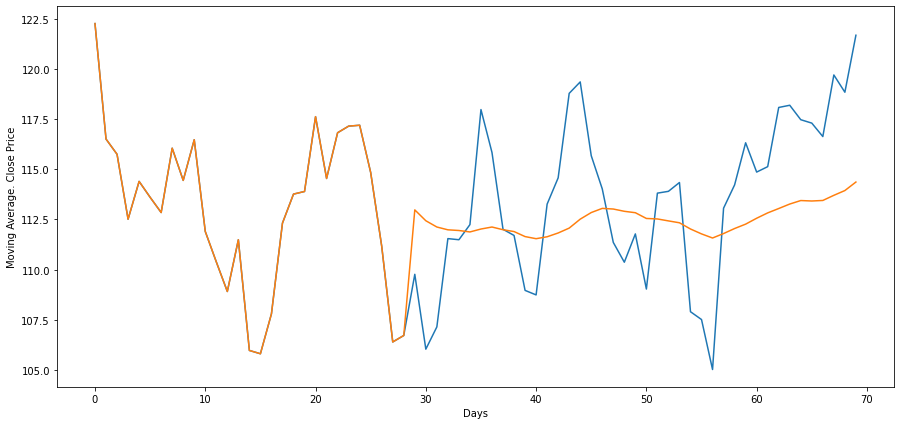

In [81]:
merge_df['Close'].plot(figsize = (15,7), xlabel = "Days", ylabel = "Moving Average. Close Price")
merge_df['sma_30'].plot()

## Splitting Data - Train and Test

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(merge_df[['Score', 'compound', 'sentiment','Open','bullish','Volume','sma_30']],
                                                    merge_df['Close'],
                                                    test_size=0.2,
                                                    random_state=42)

## Model Training



In [83]:

from sklearn.linear_model import LinearRegression
# Regression Model
model = LinearRegression()
# Train model
model.fit(X_train, Y_train)
# predict
y_pred = model.predict(X_test)

## Model Evaluation

In [87]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(Y_test, y_pred))
print("Coefficient of Determination:", r2_score(Y_test, y_pred))

Model Coefficients: [ 1.80728169e+00 -1.16450193e+00  1.97328853e-01  8.92590371e-01
  3.11723929e+00  3.06387227e-09  1.30078116e-01]
Mean Absolute Error: 1.2058609418744157
Coefficient of Determination: 0.8975598420364973


## Model Test and Predict Comparison

In [76]:
df_test_predict = pd.DataFrame(Y_test)
df_test_predict = df_test_predict.assign(predict_price = y_pred)
df_test_predict

,Close,predict_price
22,116.8205,118.397067
0,122.2610,119.810445
49,111.7775,110.778570
4,114.3950,113.869192
54,107.9000,109.867244
18,113.7620,114.700941
10,111.8995,113.272460
33,111.4875,112.319463
45,115.6765,116.158104
12,108.9080,110.220443


# SAVING RIGHT MODEL



In [78]:
import pickle

pickle.dump(model, open('stock_news_regression.pickle','wb'))

# Closing Remarks

The stock price prediction for a given ticker was based on both unstructured news data and structured variables such as opening price , closing price , volumes etc.

We first started with simple lexicion based Bing Liu sentimental analysis. Bing Liu Lexicon is based on online literature. The classfication score was not encouraging as it was around 35% accuracy.

Next we tried to apply supervised learning in order of increasing complexities.

1.** Approach 1 Model** : LinearSVC model was applied on news and the related sentimental score was regressed upon the historical closing price labels. As we observed the accuracy was around 55%.

2. **Approach 2 Model** : Pre-trained model based BERT was used and superficial trained with news. When it was regressed upon the closing price labels we got an marginal improvement in accruacy around 57%. While the expectation was much higher around 70%  per our ML Success Criteria.

3. **Approach 3 Ensemble Model** : VADER Lexicon scores and linear regression were used to regress upon other vaiables such as open price, 30 days moving average, volumes along with sentiments. With this we got much higher ML explainability AROUND 90% higher than the ML criteria of 70%